In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
from glob import glob
from ipywidgets import interact
import matplotlib.patches as patches
import pandas as pd
import json
import cv2
from PIL import Image
import seaborn as sns
from tqdm import tqdm
from time import time

# json 파일 읽고 parsing

In [11]:
IMG_PATH = "/opt/ml/detection/dataset/"
DATA_IMG_PATH = "/opt/ml/detection/dataset/train"
DATA_JSON_PATH = "/opt/ml/detection/dataset/SK_val_annotations.json"
TEST_JSON_PATH = "/opt/ml/detection/dataset/SK_val_annotations.json"

In [12]:
with open(DATA_JSON_PATH, 'r') as f:
    json_data = json.load(f)
    train_img = json_data['images']
    train_ann = json_data['annotations']
    train_categories = json_data['categories']
with open(TEST_JSON_PATH, 'r') as f:
    json_data_test = json.load(f)
    test_img = json_data_test['images']
    test_ann = json_data_test['annotations']

for main_key in list(json_data.keys()):
    print(main_key)
    if main_key == 'info':
        for key in list(json_data[main_key].keys()):
            print(f"    |_ {key}")
    else:
        for key in list(json_data[main_key][0].keys()):
            print(f"    |_ {key}")
            if(key == 'bbox'):
                print(f"        |_ xmin")
                print(f"        |_ ymin")
                print(f"        |_ width")
                print(f"        |_ height")


info
    |_ year
    |_ version
    |_ description
    |_ contributor
    |_ url
    |_ date_created
licenses
    |_ id
    |_ name
    |_ url
categories
    |_ id
    |_ name
    |_ supercategory
images
    |_ width
    |_ height
    |_ file_name
    |_ license
    |_ flickr_url
    |_ coco_url
    |_ date_captured
    |_ id
annotations
    |_ image_id
    |_ category_id
    |_ area
    |_ bbox
        |_ xmin
        |_ ymin
        |_ width
        |_ height
    |_ iscrowd
    |_ id


# class별 instance수 확인하기

In [14]:
with open('/opt/ml/detection/dataset/SK_val_annotations.json', 'r') as file:
    train_json = json.load(file)
    train_img = train_json['images']
    train_ann = train_json['annotations']

class_per_img = np.zeros(10)
for img in train_img:
    img_id = img['id']
    class_ = set()
    for ann in train_ann:
        if ann['image_id']==img_id:
            class_.add(ann['category_id'])
    for c in class_:
        class_per_img[c]+=1
print(class_per_img)
print("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

[262. 214.  80.  74.  42. 172.  63. 236.   6.  28.]
General trash Paper Paper pack Metal Glass Plastic Styrofoam Plastic bag Battery Clothing


2774.0


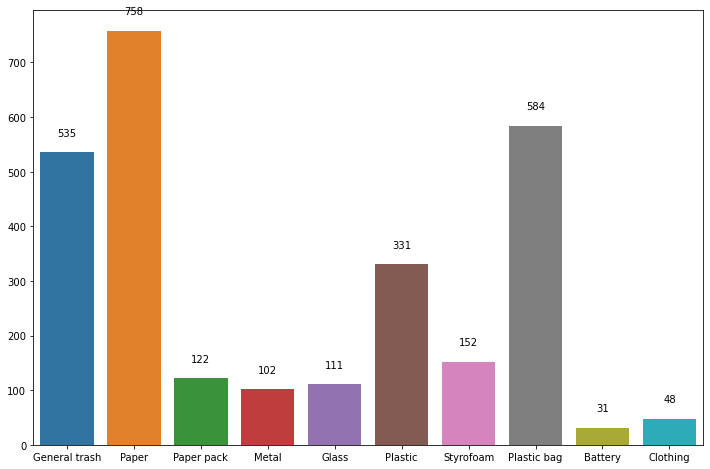

In [15]:
def countInstances(ann_data, num_cls=10):
    num_per_class = np.zeros(num_cls)
    for ann in ann_data:
        cls = ann['category_id']
        num_per_class[cls]+=1

    return num_per_class

num_per_class = countInstances(train_ann)
total_num = sum(num_per_class)
print(total_num)
categories = [category['name'] for category in train_categories]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df = pd.DataFrame(data = num_per_class, index=range(len(num_per_class)), columns=['count'])
sns.barplot(data=df, x=categories, y=num_per_class, ax=ax)

for x, y in enumerate(num_per_class):
    ax.text(x, y+30, str(int(y)),ha='center')

# image, Bbox 확인하기

In [7]:
palette = sns.color_palette('bright')

@interact(idx=(0, len(train_img)-1))
def showImg(idx=5162):
    fig, ax = plt.subplots(1, 2, dpi=200)
    ax = ax.flatten()
    img = io.imread(os.path.join('/opt/ml/detection/dataset', train_img[idx]['file_name']))
    
    ax[0].imshow(img)
    ax[1].imshow(img)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    for ann in train_ann:
        if ann['image_id']==train_img[idx]['id']:
            ann_id = ann['image_id']
            class_idx = ann['category_id']
            ax[1].set_title(str(ann_id)+'.jpg', fontsize=5)
            for pos in ['right', 'top', 'bottom', 'left']:
                ax[1].spines[pos].set_visible(False)
        
            x,y,w,h = ann['bbox']
            color = palette[class_idx]
            print(ann['bbox'])
            ax[1].add_patch(
                patches.Rectangle(
                    (x,y), w, h,
                    edgecolor=color,
                    fill=False,
                    ),
                )
            text_y = y-15 if y>15 else y+15 
            plt_text = ax[1].text(x+8,text_y, f'{categories[class_idx]}_{ann_id}', color='white', fontsize='3', weight='semibold', backgroundcolor=color)
            plt_text.set_bbox(dict(
                facecolor=palette[class_idx],  # background color
                alpha=0.6,  # background alpha
                edgecolor='none',  # border color
                pad=2
            ))


interactive(children=(IntSlider(value=4259, description='idx', max=4259), Output()), _dom_classes=('widget-int…

# Category 별 이미지 sampling

In [6]:
@interact(category_id=(0, 9))
def showing_trash(category_id):    
    fig, axes = plt.subplots(3, 3, figsize = (10, 10))
    axes = axes.flatten()
    train_ids = []
    bboxes = []
    for i in range(len(train_ann)):
        if train_ann[i]['category_id'] == category_id:
            train_ids.append(train_ann[i]['image_id'])
            bboxes.append(train_ann[i]['bbox'])
    train_ids = np.asarray(train_ids)
    bboxes=np.asarray(bboxes)
    index = np.random.choice(len(train_ids), 9)
    target_ids = train_ids[index]
    target_bboxes = bboxes[index]

    for i, (target, bbox) in enumerate(zip(target_ids, target_bboxes)):
        fname = str(int(target))
        fname = fname.zfill(4)
        fname += ".jpg"

        img = Image.open(os.path.join(DATA_IMG_PATH, fname))
        img = img.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
        
        axes[i].imshow(img) 
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(fname)
    fig.suptitle(categories[category_id], fontweight = 'bold')
    plt.show()
        

interactive(children=(IntSlider(value=4, description='category_id', max=9), Output()), _dom_classes=('widget-i…

# 넓이 분포 확인하기

In [7]:
# 각 bounding box의 area list
area_list = []
for i in range(len(train_ann)):
    area_list.append([train_ann[i]['area'], train_ann[i]['category_id']])

area_df = pd.DataFrame(area_list, columns=['Area', 'Category'])
area_df[area_df['Area']<200]

,Area,Category


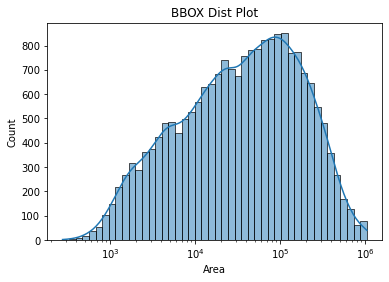

In [8]:
a_list = [area_list[i][0] for i in range(len(area_list))]
sns.histplot(area_df, x='Area', kde=True, log_scale=True)
plt.title("BBOX Dist Plot")
#plt.xscale('log')
plt.show()

In [9]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
@interact(category_id = (0, 10), area=(0, 3, 1))
def showing_area_distribution(category_id=10, area=3):
    fig, ax = plt.subplots(1, 1, figsize = (12, 7))

    if area==0:
            area_df_cut = area_df[area_df['Area']<32**2]
    elif area==1:
        area_df_cut = area_df[(area_df['Area']>=32**2)&(area_df['Area']<96**2)]
    elif area==2:
        area_df_cut = area_df[area_df['Area']>=96**2]
    else:
        area_df_cut = area_df

    try:
        area_df_cut['Category'] = area_df_cut['Category'].apply(lambda x:classes[x])
    except:
        pass

    if category_id == 10:
        sns.kdeplot(area_df_cut['Area'], hue = area_df_cut['Category'], log_scale=True, ax = ax, palette='tab10')
        plt.title(f"BBOX Dist Plot")
    else:
        target_df = area_df_cut[area_df_cut['Category'] == classes[category_id]]
        sns.histplot(target_df['Area'], kde=True, log_scale=True, ax=ax)
        plt.title(f"BBOX Dist Plot <{categories[category_id]}>")

interactive(children=(IntSlider(value=10, description='category_id', max=10), IntSlider(value=3, description='…

# 이미지당 객체 개수 확인하기 

<AxesSubplot:xlabel='count', ylabel='Count'>

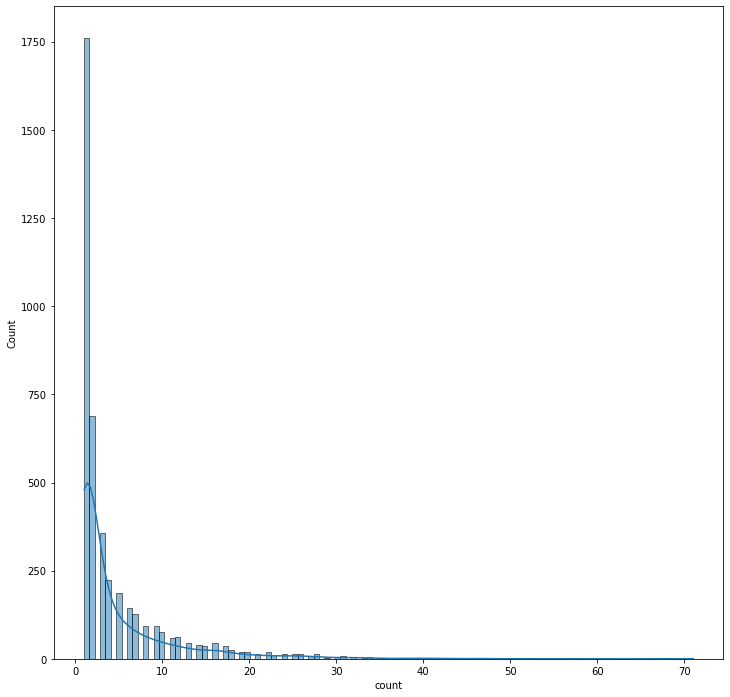

In [10]:
train_ann_df = pd.DataFrame.from_dict(train_ann)
instance_count = train_ann_df['image_id'].value_counts().sort_values()
count_df = pd.DataFrame(list(instance_count.to_dict().items()), columns=['img_id', 'count'])

fig, ax = plt.subplots(1,1, figsize=(12, 12))
sns.histplot(count_df, x='count', kde=True, ax=ax) 

In [30]:
count_df[count_df['count']>30]

,img_id,count
4831,1997,31
4832,2182,31
4833,3430,31
4834,767,31
4835,2678,31
4836,3796,31
4837,168,31
4838,840,31
4839,2572,31
4840,1669,31
